In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [3]:
# Load the dataset
data = pd.read_csv(r'D:\ML Repositories\Price_forecasting_project\data\raw\processed\Processed_test\Delicious_A_dataset.csv')

In [4]:
data

,Date,District,Market,Fruit,Variety,Grade,Min Price (per kg),Max Price (per kg),Avg Price (per kg),Mask
0,2017-09-01,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.00,0
1,2017-09-02,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.00,0
2,2017-09-03,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.00,0
3,2017-09-04,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.00,0
4,2017-09-05,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.00,0
...,...,...,...,...,...,...,...,...,...,...
2674,2024-12-27,Shopian,Aglar,Apple,Delicious,A,50.0,62.5,56.25,1
2675,2024-12-28,Shopian,Aglar,Apple,Delicious,A,50.0,62.5,56.25,1
2676,2024-12-29,Shopian,Aglar,Apple,Delicious,A,50.0,62.5,56.25,1
2677,2024-12-30,Shopian,Aglar,Apple,Delicious,A,50.0,62.5,56.25,1


In [5]:
data.columns

Index(['Date', 'District', 'Market', 'Fruit', 'Variety', 'Grade',
       'Min Price (per kg)', 'Max Price (per kg)', 'Avg Price (per kg)',
       'Mask'],
      dtype='object')

In [6]:
# Ensure proper datetime format for models requiring 'ds'
data = data.rename(columns={"Date": "ds", "Avg Price (per kg)": "y"})
data['ds'] = pd.to_datetime(data['ds'])

In [7]:
# Filter for available data (Mask=1) for SARIMA and Prophet
available_data = data[data['Mask'] == 1].copy()

In [8]:
available_data.reset_index(inplace=True)

In [9]:
# Split data for training and testing
train_data = available_data[available_data['ds'] < '2024-09-15']
test_data = available_data[available_data['ds'] >= '2024-09-15']

<Axes: >

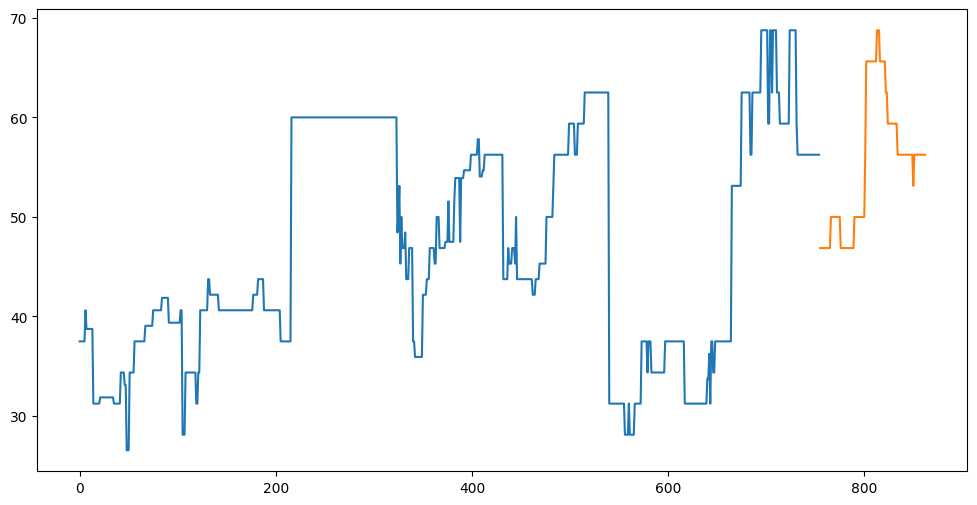

In [10]:
plt.figure(figsize=(12,6))
train_data['y'].plot()
test_data['y'].plot()

In [11]:
# Create a function to reverse scaling
def reverse_scaling(scaled_values, data):
    return scaled_values * (data['y'].max() - data['y'].min()) + data['y'].min()

In [98]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

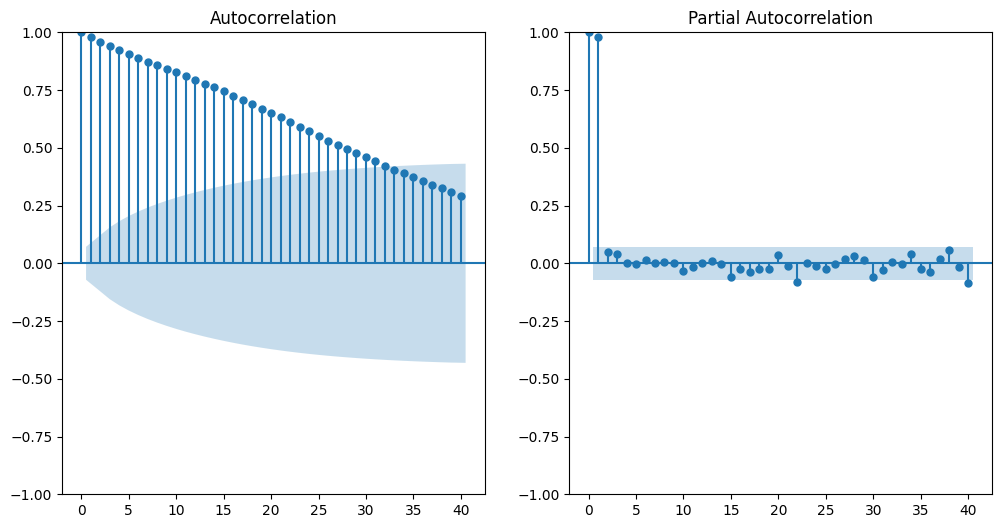

In [100]:
# Plot ACF and PACF for the given time series
plt.figure(figsize=(12, 6))

# ACF Plot
plt.subplot(1, 2, 1)
plot_acf(train_data['y'], lags=40, ax=plt.gca())

# PACF Plot
plt.subplot(1, 2, 2)
plot_pacf(train_data['y'], lags=40, ax=plt.gca())

plt.show()


In [102]:
# Define the range of parameters for grid search
p_values = range(0, 3)  # AR terms
d_values = range(0, 2)  # Differencing terms
q_values = range(0, 3)  # MA terms
P_values = range(0, 3)  # Seasonal AR terms
D_values = range(0, 2)  # Seasonal differencing terms
Q_values = range(0, 3)  # Seasonal MA terms
seasonal_periods = [12]  # Seasonal period (e.g., 12 for monthly data with yearly seasonality)

# Prepare parameter combinations
param_grid = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, seasonal_periods))

# Initialize a list to store results
results = []

# Check if the dataset has missing values
if train_data['y'].isnull().sum() > 0:
    print("Warning: The dataset contains missing values. Consider imputing or removing them.")
else:
    print("No missing values detected in the data.")

# Loop through all parameter combinations
for param in param_grid:
    try:
        # Unpack the parameters
        p, d, q, P, D, Q, S = param

        # Define and fit the SARIMA model with the current parameters
        sarima_model = SARIMAX(train_data['y'],
                               order=(p, d, q),             # (p, d, q)
                               seasonal_order=(P, D, Q, S),  # (P, D, Q, S)
                               enforce_stationarity=False,   # Avoid stationarity constraint for SARIMA
                               enforce_invertibility=False)  # Avoid invertibility constraint for SARIMA
        
        # Fit the model
        sarima_results = sarima_model.fit(disp=False)

        # Store the model parameters and AIC
        results.append((param, sarima_results.aic))
        print(f"Successfully fitted model with parameters {param}. AIC: {sarima_results.aic}")

    except Exception as e:
        print(f"Error fitting model with parameters {param}: {e}")
        continue

# Check if any results were generated
if results:
    # Convert the results into a DataFrame
    results_df = pd.DataFrame(results, columns=["Params", "AIC"])

    # Sort by AIC and display the best parameters
    best_params = results_df.sort_values(by="AIC").iloc[0]
    print("\nBest Parameters:", best_params)
else:
    print("No valid SARIMA models were successfully fitted. Please review your data and parameter ranges.")


No missing values detected in the data.
Successfully fitted model with parameters (0, 0, 0, 0, 0, 0, 12). AIC: 7989.164988514268
Successfully fitted model with parameters (0, 0, 0, 0, 0, 1, 12). AIC: 7011.962475073538
Successfully fitted model with parameters (0, 0, 0, 0, 0, 2, 12). AIC: 6315.1967007274
Successfully fitted model with parameters (0, 0, 0, 0, 1, 0, 12). AIC: 5026.1219421118985
Successfully fitted model with parameters (0, 0, 0, 0, 1, 1, 12). AIC: 4947.777419003383
Successfully fitted model with parameters (0, 0, 0, 0, 1, 2, 12). AIC: 4878.168256628598
Successfully fitted model with parameters (0, 0, 0, 1, 0, 0, 12). AIC: 5033.049035885782
Successfully fitted model with parameters (0, 0, 0, 1, 0, 1, 12). AIC: 5028.696404850647
Successfully fitted model with parameters (0, 0, 0, 1, 0, 2, 12). AIC: 4950.279010187745
Successfully fitted model with parameters (0, 0, 0, 1, 1, 0, 12). AIC: 4954.509780646284
Successfully fitted model with parameters (0, 0, 0, 1, 1, 1, 12). AIC: 

c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (0, 0, 1, 1, 0, 1, 12). AIC: 4433.779020034764
Successfully fitted model with parameters (0, 0, 1, 1, 0, 2, 12). AIC: 4348.902032213694
Successfully fitted model with parameters (0, 0, 1, 1, 1, 0, 12). AIC: 4362.308877840241
Successfully fitted model with parameters (0, 0, 1, 1, 1, 1, 12). AIC: 4318.9359984754565
Successfully fitted model with parameters (0, 0, 1, 1, 1, 2, 12). AIC: 4252.120628584055
Successfully fitted model with parameters (0, 0, 1, 2, 0, 0, 12). AIC: 4363.558784466966


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (0, 0, 1, 2, 0, 1, 12). AIC: 4327.423149648732


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (0, 0, 1, 2, 0, 2, 12). AIC: 4374.045606824782
Successfully fitted model with parameters (0, 0, 1, 2, 1, 0, 12). AIC: 4300.243165932335
Successfully fitted model with parameters (0, 0, 1, 2, 1, 1, 12). AIC: 4259.212967008046
Successfully fitted model with parameters (0, 0, 1, 2, 1, 2, 12). AIC: 4248.038294700124
Successfully fitted model with parameters (0, 0, 2, 0, 0, 0, 12). AIC: 6186.973127251713
Successfully fitted model with parameters (0, 0, 2, 0, 0, 1, 12). AIC: 5483.3270769833525
Successfully fitted model with parameters (0, 0, 2, 0, 0, 2, 12). AIC: 5079.531275926952
Successfully fitted model with parameters (0, 0, 2, 0, 1, 0, 12). AIC: 4173.709616716657
Successfully fitted model with parameters (0, 0, 2, 0, 1, 1, 12). AIC: 4064.7391347779158
Successfully fitted model with parameters (0, 0, 2, 0, 1, 2, 12). AIC: 4006.457711547433
Successfully fitted model with parameters (0, 0, 2, 1, 0, 0, 12). AIC: 4189.588054716851


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (0, 0, 2, 1, 0, 1, 12). AIC: 4188.790446307505
Successfully fitted model with parameters (0, 0, 2, 1, 0, 2, 12). AIC: 4065.704508683175
Successfully fitted model with parameters (0, 0, 2, 1, 1, 0, 12). AIC: 4088.5410918612683
Successfully fitted model with parameters (0, 0, 2, 1, 1, 1, 12). AIC: 4039.8665330932618
Successfully fitted model with parameters (0, 0, 2, 1, 1, 2, 12). AIC: 3976.2579933500037
Successfully fitted model with parameters (0, 0, 2, 2, 0, 0, 12). AIC: 4089.442999712497


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (0, 0, 2, 2, 0, 1, 12). AIC: 4054.955098622411


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (0, 0, 2, 2, 0, 2, 12). AIC: 4085.186852885226
Successfully fitted model with parameters (0, 0, 2, 2, 1, 0, 12). AIC: 4029.0373763958887
Successfully fitted model with parameters (0, 0, 2, 2, 1, 1, 12). AIC: 3993.692829072108
Successfully fitted model with parameters (0, 0, 2, 2, 1, 2, 12). AIC: 3970.2651936274037
Successfully fitted model with parameters (0, 1, 0, 0, 0, 0, 12). AIC: 3416.1423142786416
Successfully fitted model with parameters (0, 1, 0, 0, 0, 1, 12). AIC: 3372.99479603456
Successfully fitted model with parameters (0, 1, 0, 0, 0, 2, 12). AIC: 3322.1613089170246
Successfully fitted model with parameters (0, 1, 0, 0, 1, 0, 12). AIC: 3899.2688537904855
Successfully fitted model with parameters (0, 1, 0, 0, 1, 1, 12). AIC: 3357.7210095683317
Successfully fitted model with parameters (0, 1, 0, 0, 1, 2, 12). AIC: 3314.8916836397702
Successfully fitted model with parameters (0, 1, 0, 1, 0, 0, 12). AIC: 3376.5430634204013
Successfully f

c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (1, 0, 0, 0, 0, 2, 12). AIC: 3340.1489958221377
Successfully fitted model with parameters (1, 0, 0, 0, 1, 0, 12). AIC: 3863.4862994805344
Successfully fitted model with parameters (1, 0, 0, 0, 1, 1, 12). AIC: 3355.681807613361
Successfully fitted model with parameters (1, 0, 0, 0, 1, 2, 12). AIC: 3313.5315763503054
Successfully fitted model with parameters (1, 0, 0, 1, 0, 0, 12). AIC: 3378.4019493872324
Successfully fitted model with parameters (1, 0, 0, 1, 0, 1, 12). AIC: 3380.4011619789103
Successfully fitted model with parameters (1, 0, 0, 1, 0, 2, 12). AIC: 3329.6301177024693
Successfully fitted model with parameters (1, 0, 0, 1, 1, 0, 12). AIC: 3604.8597879320387
Successfully fitted model with parameters (1, 0, 0, 1, 1, 1, 12). AIC: 3357.6814340326005
Successfully fitted model with parameters (1, 0, 0, 1, 1, 2, 12). AIC: 3314.56462897855
Successfully fitted model with parameters (1, 0, 0, 2, 0, 0, 12). AIC: 3327.6368003103253
Successfully 

c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (1, 0, 1, 0, 0, 2, 12). AIC: 3337.7313564174656
Successfully fitted model with parameters (1, 0, 1, 0, 1, 0, 12). AIC: 3861.2791007119695
Successfully fitted model with parameters (1, 0, 1, 0, 1, 1, 12). AIC: 3352.1133573091206
Successfully fitted model with parameters (1, 0, 1, 0, 1, 2, 12). AIC: 3309.905106640941
Successfully fitted model with parameters (1, 0, 1, 1, 0, 0, 12). AIC: 3377.3726320237015
Successfully fitted model with parameters (1, 0, 1, 1, 0, 1, 12). AIC: 3375.785725763774
Successfully fitted model with parameters (1, 0, 1, 1, 0, 2, 12). AIC: 3324.99225205571
Successfully fitted model with parameters (1, 0, 1, 1, 1, 0, 12). AIC: 3606.493842954761
Successfully fitted model with parameters (1, 0, 1, 1, 1, 1, 12). AIC: 3354.1129212355822
Successfully fitted model with parameters (1, 0, 1, 1, 1, 2, 12). AIC: 3310.9868324447652
Successfully fitted model with parameters (1, 0, 1, 2, 0, 0, 12). AIC: 3326.5479480506074
Successfully fi

c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (1, 0, 2, 0, 0, 2, 12). AIC: 3332.9725415317675
Successfully fitted model with parameters (1, 0, 2, 0, 1, 0, 12). AIC: 3853.7314245622965
Successfully fitted model with parameters (1, 0, 2, 0, 1, 1, 12). AIC: 3349.7131055788923
Successfully fitted model with parameters (1, 0, 2, 0, 1, 2, 12). AIC: 3301.3578926317373
Successfully fitted model with parameters (1, 0, 2, 1, 0, 0, 12). AIC: 3377.70784922447
Successfully fitted model with parameters (1, 0, 2, 1, 0, 1, 12). AIC: 3362.310922261786


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (1, 0, 2, 1, 0, 2, 12). AIC: 3321.7548754730706
Successfully fitted model with parameters (1, 0, 2, 1, 1, 0, 12). AIC: 3608.468699261448
Successfully fitted model with parameters (1, 0, 2, 1, 1, 1, 12). AIC: 3351.712142129942
Successfully fitted model with parameters (1, 0, 2, 1, 1, 2, 12). AIC: 3302.019369882676
Successfully fitted model with parameters (1, 0, 2, 2, 0, 0, 12). AIC: 3326.855581923057
Successfully fitted model with parameters (1, 0, 2, 2, 0, 1, 12). AIC: 3328.8482425616753


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (1, 0, 2, 2, 0, 2, 12). AIC: 3325.0422653615337
Successfully fitted model with parameters (1, 0, 2, 2, 1, 0, 12). AIC: 3492.48108819298
Successfully fitted model with parameters (1, 0, 2, 2, 1, 1, 12). AIC: 3316.1282894072287
Successfully fitted model with parameters (1, 0, 2, 2, 1, 2, 12). AIC: 3304.019053598824
Successfully fitted model with parameters (1, 1, 0, 0, 0, 0, 12). AIC: 3415.2358791346205
Successfully fitted model with parameters (1, 1, 0, 0, 0, 1, 12). AIC: 3372.2176509241526
Successfully fitted model with parameters (1, 1, 0, 0, 0, 2, 12). AIC: 3321.34087402308
Successfully fitted model with parameters (1, 1, 0, 0, 1, 0, 12). AIC: 3899.1750486154187
Successfully fitted model with parameters (1, 1, 0, 0, 1, 1, 12). AIC: 3357.3963417557543
Successfully fitted model with parameters (1, 1, 0, 0, 1, 2, 12). AIC: 3314.246084632583
Successfully fitted model with parameters (1, 1, 0, 1, 0, 0, 12). AIC: 3372.221025741174
Successfully fitt

c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 0, 0, 0, 2, 12). AIC: 3340.5829066950473
Successfully fitted model with parameters (2, 0, 0, 0, 1, 0, 12). AIC: 3861.2792354811
Successfully fitted model with parameters (2, 0, 0, 0, 1, 1, 12). AIC: 3356.468483178312
Successfully fitted model with parameters (2, 0, 0, 0, 1, 2, 12). AIC: 3313.6879381299145
Successfully fitted model with parameters (2, 0, 0, 1, 0, 0, 12). AIC: 3374.119289997382
Successfully fitted model with parameters (2, 0, 0, 1, 0, 1, 12). AIC: 3376.117414895746
Successfully fitted model with parameters (2, 0, 0, 1, 0, 2, 12). AIC: 3328.8383883865545
Successfully fitted model with parameters (2, 0, 0, 1, 1, 0, 12). AIC: 3602.550111932529
Successfully fitted model with parameters (2, 0, 0, 1, 1, 1, 12). AIC: 3354.2574782237375
Successfully fitted model with parameters (2, 0, 0, 1, 1, 2, 12). AIC: 3315.115383107497
Successfully fitted model with parameters (2, 0, 0, 2, 0, 0, 12). AIC: 3323.3048404563233
Successfully fitte

c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 0, 2, 0, 2, 12). AIC: 3327.2828966759103
Successfully fitted model with parameters (2, 0, 0, 2, 1, 0, 12). AIC: 3487.2973442683624
Successfully fitted model with parameters (2, 0, 0, 2, 1, 1, 12). AIC: 3311.1846991230504
Successfully fitted model with parameters (2, 0, 0, 2, 1, 2, 12). AIC: 3311.2088442608692
Successfully fitted model with parameters (2, 0, 1, 0, 0, 0, 12). AIC: 3417.496105233956
Successfully fitted model with parameters (2, 0, 1, 0, 0, 1, 12). AIC: 3371.9480093466045


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 1, 0, 0, 2, 12). AIC: 3381.626212738882
Successfully fitted model with parameters (2, 0, 1, 0, 1, 0, 12). AIC: 3863.2674630978836
Successfully fitted model with parameters (2, 0, 1, 0, 1, 1, 12). AIC: 3354.699508245807
Successfully fitted model with parameters (2, 0, 1, 0, 1, 2, 12). AIC: 3312.4514721916203


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 1, 1, 0, 0, 12). AIC: 3372.0041725940764


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 1, 1, 0, 1, 12). AIC: 3374.6902660759997


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 1, 1, 0, 2, 12). AIC: 3330.8372995595696
Successfully fitted model with parameters (2, 0, 1, 1, 1, 0, 12). AIC: 3604.5825643083317
Successfully fitted model with parameters (2, 0, 1, 1, 1, 1, 12). AIC: 3356.7038004178767


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 1, 1, 1, 2, 12). AIC: 3313.533872717235


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 1, 2, 0, 0, 12). AIC: 3325.138465400838


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 1, 2, 0, 1, 12). AIC: 3331.7273360549316


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 1, 2, 0, 2, 12). AIC: 3333.2902006460795
Successfully fitted model with parameters (2, 0, 1, 2, 1, 0, 12). AIC: 3489.4373642982882
Successfully fitted model with parameters (2, 0, 1, 2, 1, 1, 12). AIC: 3313.7758254989435


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 1, 2, 1, 2, 12). AIC: 3313.6922747793105
Successfully fitted model with parameters (2, 0, 2, 0, 0, 0, 12). AIC: 3415.580707551578


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 2, 0, 0, 1, 12). AIC: 3362.310480628463


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 2, 0, 0, 2, 12). AIC: 3332.27802718888
Successfully fitted model with parameters (2, 0, 2, 0, 1, 0, 12). AIC: 3855.64417028999
Successfully fitted model with parameters (2, 0, 2, 0, 1, 1, 12). AIC: 3351.8001213167427
Successfully fitted model with parameters (2, 0, 2, 0, 1, 2, 12). AIC: 3303.2416716092466


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 2, 1, 0, 0, 12). AIC: 3373.9798412461996
Successfully fitted model with parameters (2, 0, 2, 1, 0, 1, 12). AIC: 3364.333685122295
Successfully fitted model with parameters (2, 0, 2, 1, 0, 2, 12). AIC: 3323.7568322135676
Successfully fitted model with parameters (2, 0, 2, 1, 1, 0, 12). AIC: 3606.5373732129965


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 2, 1, 1, 1, 12). AIC: 3353.6870178378535
Successfully fitted model with parameters (2, 0, 2, 1, 1, 2, 12). AIC: 3303.8342805992675
Successfully fitted model with parameters (2, 0, 2, 2, 0, 0, 12). AIC: 3325.3080794902935
Successfully fitted model with parameters (2, 0, 2, 2, 0, 1, 12). AIC: 3327.300950670116


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 2, 2, 0, 2, 12). AIC: 3325.7587723742304
Successfully fitted model with parameters (2, 0, 2, 2, 1, 0, 12). AIC: 3490.62507712118
Successfully fitted model with parameters (2, 0, 2, 2, 1, 1, 12). AIC: 3312.5640500674344
Successfully fitted model with parameters (2, 0, 2, 2, 1, 2, 12). AIC: 3305.833416819316
Successfully fitted model with parameters (2, 1, 0, 0, 0, 0, 12). AIC: 3411.750476561285
Successfully fitted model with parameters (2, 1, 0, 0, 0, 1, 12). AIC: 3372.3439092248655
Successfully fitted model with parameters (2, 1, 0, 0, 0, 2, 12). AIC: 3321.4061330199547
Successfully fitted model with parameters (2, 1, 0, 0, 1, 0, 12). AIC: 3888.257266000156
Successfully fitted model with parameters (2, 1, 0, 0, 1, 1, 12). AIC: 3359.1118588787485
Successfully fitted model with parameters (2, 1, 0, 0, 1, 2, 12). AIC: 3314.61586851642
Successfully fitted model with parameters (2, 1, 0, 1, 0, 0, 12). AIC: 3358.4978031630667
Successfully fitt

c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 1, 2, 0, 1, 1, 12). AIC: 3352.7947759632566
Successfully fitted model with parameters (2, 1, 2, 0, 1, 2, 12). AIC: 3305.7644138785117
Successfully fitted model with parameters (2, 1, 2, 1, 0, 0, 12). AIC: 3362.26666103636
Successfully fitted model with parameters (2, 1, 2, 1, 0, 1, 12). AIC: 3360.771011301422
Successfully fitted model with parameters (2, 1, 2, 1, 0, 2, 12). AIC: 3320.155040641326
Successfully fitted model with parameters (2, 1, 2, 1, 1, 0, 12). AIC: 3620.9449190749124
Successfully fitted model with parameters (2, 1, 2, 1, 1, 1, 12). AIC: 3355.9791015206683
Successfully fitted model with parameters (2, 1, 2, 1, 1, 2, 12). AIC: 3306.2436122043946
Successfully fitted model with parameters (2, 1, 2, 2, 0, 0, 12). AIC: 3321.7166539223167
Successfully fitted model with parameters (2, 1, 2, 2, 0, 1, 12). AIC: 3323.712251546527
Successfully fitted model with parameters (2, 1, 2, 2, 0, 2, 12). AIC: 3322.147456404767
Successfully fit

c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 1, 2, 2, 1, 2, 12). AIC: 3308.251919640248

Best Parameters: Params    (1, 0, 2, 0, 1, 2, 12)
AIC                  3301.357893
Name: 149, dtype: object


In [103]:
#######################################
# SARIMA Model
#######################################
sarima_model = SARIMAX(train_data['y'], 
                       order=(1, 0, 2),
                       seasonal_order=(0, 1, 2, 12))
sarima_results = sarima_model.fit(disp=False)

sarima_forecast = sarima_results.get_forecast(steps=len(test_data))
sarima_pred = sarima_forecast.predicted_mean


In [105]:
sarima_pred

755    56.256735
756    55.121664
757    55.043953
758    55.119646
759    55.117981
         ...    
858    50.736460
859    50.495975
860    51.062789
861    51.103304
862    50.840972
Name: predicted_mean, Length: 108, dtype: float64

<Axes: >

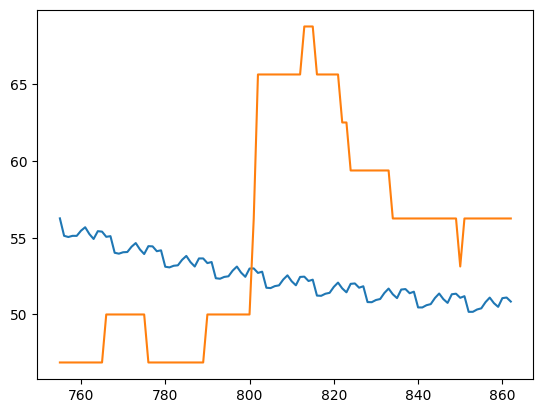

In [109]:
sarima_pred.plot()
test_data['y'].plot()

In [246]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE and MAE for Random Forest predictions
sarima_mse = mean_squared_error(test_data[test_data['Mask'] == 1]['y'], sarima_pred)
sarima_mae = mean_absolute_error(test_data[test_data['Mask'] == 1]['y'], sarima_pred)

print(f"Random Forest - Mean Squared Error (MSE): {sarima_mse}")
print(f"Random Forest - Mean Absolute Error (MAE): {sarima_mae}")

Random Forest - Mean Squared Error (MSE): 68.45230075072547
Random Forest - Mean Absolute Error (MAE): 7.40151307192574


In [117]:
from prophet import Prophet
#######################################
# Prophet Model
#######################################
prophet_model = Prophet()
prophet_model.fit(train_data[['ds', 'y']].rename(columns={'ds': 'ds', 'y': 'y'}))
future = prophet_model.make_future_dataframe(periods=len(test_data))
prophet_forecast = prophet_model.predict(future)
prophet_pred = prophet_forecast['yhat'][-len(test_data):]

14:15:51 - cmdstanpy - INFO - Chain [1] start processing
14:15:51 - cmdstanpy - INFO - Chain [1] done processing


In [118]:
prophet_pred

755    60.369977
756    60.091817
757    59.342161
758    58.596810
759    57.496296
         ...    
858    63.154248
859    60.321039
860    57.516199
861    54.829069
862    52.098173
Name: yhat, Length: 108, dtype: float64

In [247]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE and MAE for Random Forest predictions
prophet_mse = mean_squared_error(test_data[test_data['Mask'] == 1]['y'], prophet_pred)
prophet_mae = mean_absolute_error(test_data[test_data['Mask'] == 1]['y'], prophet_pred)

print(f"Prophet - Mean Squared Error (MSE): {prophet_mse}")
print(f"Prophet - Mean Absolute Error (MAE): {prophet_mae}")


Prophet - Mean Squared Error (MSE): 344.99740804342974
Prophet - Mean Absolute Error (MAE): 16.320781585030208


<Axes: >

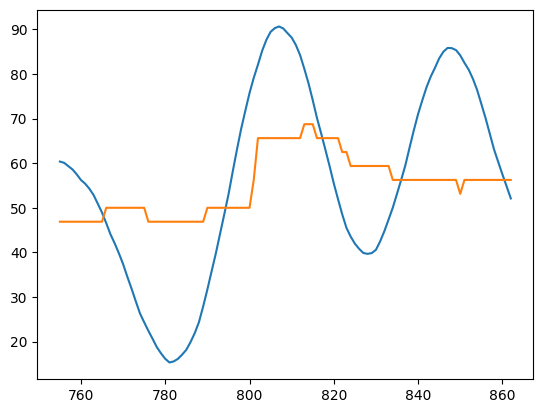

In [120]:
prophet_pred.plot()
test_data['y'].plot()

In [140]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Function to create lagged features
def create_lagged_features(data, max_lag):
    for lag in range(1, max_lag + 1):
        data[f'y_lag{lag}'] = data['y'].shift(lag)
    # Do not drop NaN values to preserve data length, but apply mask later
    return data

# Function to find optimal lags
def find_best_lags(model, train_data, val_data, features, max_lag):
    best_lags, best_mse = 0, float('inf')
    for num_lags in range(1, max_lag + 1):
        lag_features = features[:num_lags]
        model.fit(train_data[lag_features], train_data['y'])
        val_predictions = model.predict(val_data[lag_features])
        mse = mean_squared_error(val_data['y'], val_predictions)
        if mse < best_mse:
            best_mse, best_lags = mse, num_lags
    return best_lags, best_mse

# Split data into training and testing sets
train_data = available_data[available_data['ds'] < '2024-09-15']
test_data = available_data[available_data['ds'] >= '2024-09-15']

# Generate lagged features without dropping NaNs
max_lag = 60
train_data = create_lagged_features(train_data, max_lag)
test_data = create_lagged_features(test_data, max_lag)

# Split training data into train and validation subsets
train_subset = train_data[train_data['ds'] < '2023-09-15']
# Ensure validation set does not include data that will be in the test set
val_subset = train_data[(train_data['ds'] >= '2023-09-15') & (train_data['ds'] < '2024-09-15')]


# Define features
features = [f'y_lag{i}' for i in range(1, max_lag + 1)]

# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
best_lags_rf, best_mse_rf = find_best_lags(rf_model, train_subset, val_subset, features, max_lag)

# Train final RF model
final_rf_features = features[:best_lags_rf]
rf_model.fit(train_data[final_rf_features], train_data['y'])
rf_predictions = rf_model.predict(test_data[final_rf_features])

# XGBoost Model with scaling
scaler = StandardScaler()
train_data['y_scaled'] = scaler.fit_transform(train_data[['y']])
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
best_lags_xgb, best_mse_xgb = find_best_lags(xgb_model, train_subset, val_subset, features, max_lag)

# Train final XGBoost model
final_xgb_features = features[:best_lags_xgb]
xgb_model.fit(train_data[final_xgb_features], train_data['y_scaled'])
xgb_predictions_scaled = xgb_model.predict(test_data[final_xgb_features])
xgb_predictions = scaler.inverse_transform(xgb_predictions_scaled.reshape(-1, 1))

# Ensure predictions and test_data are aligned and of the same length
rf_pred_aligned = rf_predictions[:len(test_data)]
xgb_pred_aligned = xgb_predictions[:len(test_data)]

# Apply mask to exclude missing data (Mask == 0)
if 'Mask' in test_data.columns:
    rf_pred_aligned = rf_pred_aligned[test_data['Mask'] == 1]
    xgb_pred_aligned = xgb_pred_aligned[test_data['Mask'] == 1]


C:\Windows\Temp\ipykernel_15324\487008908.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'y_lag{lag}'] = data['y'].shift(lag)
C:\Windows\Temp\ipykernel_15324\487008908.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'y_lag{lag}'] = data['y'].shift(lag)
C:\Windows\Temp\ipykernel_15324\487008908.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [141]:
rf_pred_aligned

array([37.95610498, 46.6125    , 46.590625  , 46.31584821, 45.55022321,
       46.140625  , 46.64375   , 47.09375   , 47.09375   , 47.09375   ,
       47.09375   , 47.09375   , 47.4296875 , 48.190625  , 48.196875  ,
       48.109375  , 48.5       , 49.7515625 , 51.896875  , 51.896875  ,
       51.896875  , 51.896875  , 47.384375  , 46.95      , 46.9375    ,
       46.94375   , 47.009375  , 47.2625    , 47.09375   , 47.09375   ,
       47.09375   , 47.09375   , 47.09375   , 47.09375   , 47.09375   ,
       47.09375   , 47.4296875 , 48.190625  , 48.196875  , 48.109375  ,
       48.5       , 49.7515625 , 51.896875  , 51.896875  , 51.896875  ,
       51.896875  , 51.896875  , 55.62578125, 62.44375   , 62.5       ,
       62.5625    , 62.5       , 62.5       , 62.42737269, 61.2408224 ,
       61.2408224 , 61.2408224 , 61.2408224 , 61.2408224 , 68.68478261,
       68.6875    , 68.6875    , 63.38632285, 62.63837031, 61.79332613,
       61.58774359, 61.52126563, 61.06527416, 61.2408224 , 61.24

In [253]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE and MAE for Random Forest predictions
rf_mse = mean_squared_error(test_data[test_data['Mask'] == 1]['y'], rf_pred_aligned)
rf_mae = mean_absolute_error(test_data[test_data['Mask'] == 1]['y'], rf_pred_aligned)

print(f"Random Forest - Mean Squared Error (MSE): {rf_mse}")
print(f"Random Forest - Mean Absolute Error (MAE): {rf_mae}")


Random Forest - Mean Squared Error (MSE): 5.995637677535872
Random Forest - Mean Absolute Error (MAE): 1.5779514384969748


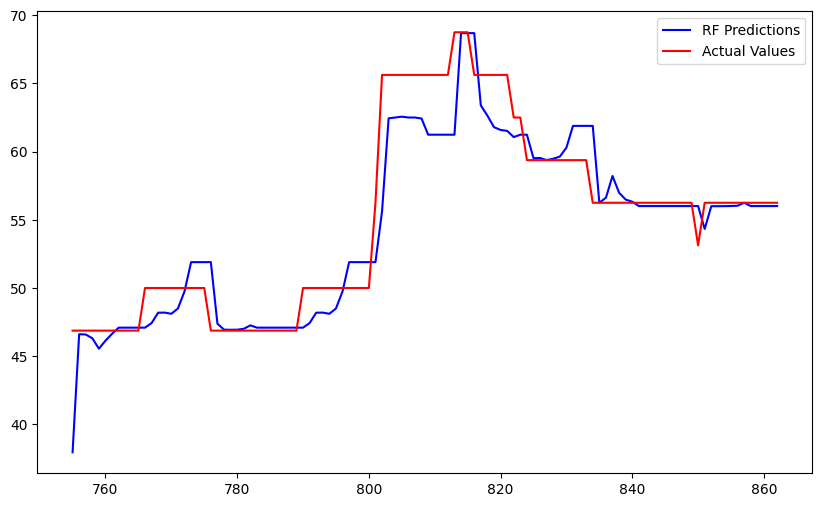

In [144]:
import matplotlib.pyplot as plt

# Convert rf_pred_aligned to a Pandas Series with the same index as test_data
rf_pred_series = pd.Series(rf_pred_aligned, index=test_data.index)

# Plot the predictions and actual values
plt.figure(figsize=(10, 6))
rf_pred_series.plot(label='RF Predictions', color='blue')
test_data['y'].plot(label='Actual Values', color='red')
plt.legend()
plt.show()


In [248]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Calculate MSE and MAE for LSTM predictions
xgb_mse = mean_squared_error(test_data[test_data['Mask'] == 1]['y'], xgb_pred_aligned)
xgb_mae = mean_absolute_error(test_data[test_data['Mask'] == 1]['y'], xgb_pred_aligned)

print(f"XGB - Mean Squared Error (MSE): {xgb_mse}")
print(f"XGB - Mean Absolute Error (MAE): {xgb_mae}")

XGB - Mean Squared Error (MSE): 6.2799591440345
XGB - Mean Absolute Error (MAE): 1.569589720831977


In [136]:
xgb_pred_aligned

array([[37.500877],
       [47.531017],
       [47.635334],
       [47.500465],
       [48.290066],
       [48.511692],
       [47.002247],
       [47.002247],
       [47.002247],
       [47.002247],
       [47.002247],
       [47.002247],
       [45.702866],
       [47.85399 ],
       [48.814293],
       [49.099476],
       [49.620045],
       [51.679626],
       [51.679626],
       [51.679626],
       [51.679626],
       [51.679626],
       [46.938683],
       [46.907475],
       [46.8663  ],
       [46.96618 ],
       [46.960434],
       [47.002247],
       [47.002247],
       [47.002247],
       [47.002247],
       [47.002247],
       [47.002247],
       [47.002247],
       [47.002247],
       [47.002247],
       [45.702866],
       [47.85399 ],
       [48.814293],
       [49.099476],
       [49.620045],
       [51.679626],
       [51.679626],
       [51.679626],
       [51.679626],
       [51.679626],
       [51.679626],
       [56.172684],
       [62.49904 ],
       [62.438232],


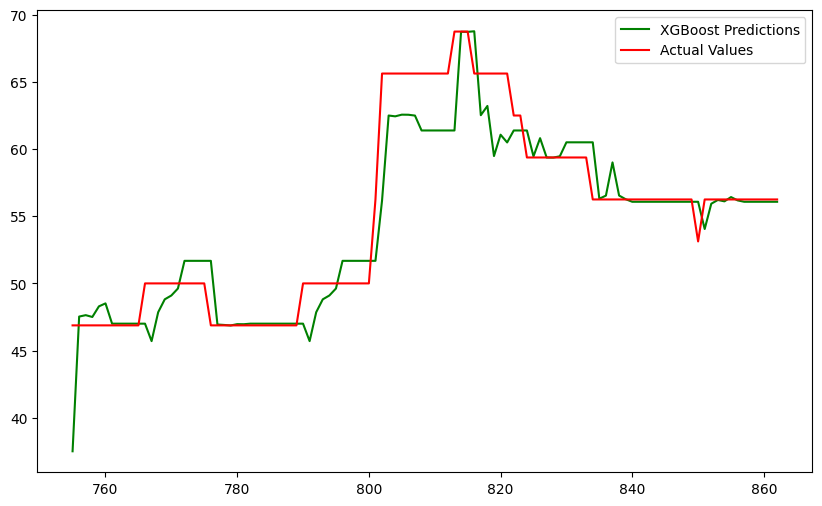

In [146]:
import matplotlib.pyplot as plt

# Convert xgb_pred_aligned to a 1-dimensional array and then to a Pandas Series with the same index as test_data
xgb_pred_series = pd.Series(xgb_pred_aligned.ravel(), index=test_data.index)

# Plot the predictions and actual values
plt.figure(figsize=(10, 6))
xgb_pred_series.plot(label='XGBoost Predictions', color='green')
test_data['y'].plot(label='Actual Values', color='red')
plt.legend()
plt.show()


In [13]:
# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [226]:
# Define function to reverse scaling (to original range)
def reverse_scaling(predictions, data):
    return predictions * (data['y'].max() - data['y'].min()) + data['y'].min()

# Split the data into train and test (after defining 'Mask')
train_data = data[data['ds'] < '2024-09-15']
test_data = data[data['ds'] >= '2024-09-15']

# Apply MinMax scaling only on the training data
scaler = MinMaxScaler()
train_scaled = train_data[['y']]
train_scaled['y'] = scaler.fit_transform(train_scaled)

# Apply the same scaler to the test data (to avoid leakage)
test_scaled = test_data[['y']]
test_scaled['y'] = scaler.transform(test_scaled)

# Evaluate different sequence lengths (lags)
lags = [1, 2, 3, 5, 10, 15, 20, 30, 35, 40, 45, 50]  # List of lags to try
best_mse = float('inf')  # Initialize best MSE as a large number
best_seq_length = None
best_lstm_pred = None

# ONLY create sequences using train data and then test the model on the test data
for seq_length in lags:
    # Create sequences ONLY using training data
    X_train, y_train = create_sequences(train_scaled['y'].values, seq_length)
    X_test, y_test = create_sequences(test_scaled['y'].values, seq_length)

    # Reshape input for LSTM: [samples, time steps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build LSTM model
    lstm_model = Sequential([
        LSTM(100, activation='relu', input_shape=(seq_length, 1)),
        Dense(1)
    ])
    lstm_model.compile(optimizer='adam', loss='mse')

    # Train the LSTM model
    lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    # Make predictions
    lstm_pred = lstm_model.predict(X_test)

    # Reverse scaling to get predictions back to original values
    lstm_pred = reverse_scaling(lstm_pred, data)

    # Calculate MSE for the current sequence length
    mse = mean_squared_error(y_test, lstm_pred)

    # Update best MSE and best sequence length
    if mse < best_mse:
        best_mse = mse
        best_seq_length = seq_length
        best_lstm_pred = lstm_pred

# Print the best sequence length and its MSE
print(f"Best Sequence Length (Lag): {best_seq_length}")
print(f"Best MSE: {best_mse}")


C:\Windows\Temp\ipykernel_15324\220672167.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_scaled['y'] = scaler.fit_transform(train_scaled)
C:\Windows\Temp\ipykernel_15324\220672167.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_scaled['y'] = scaler.transform(test_scaled)
c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Best Sequence Length (Lag): 1
Best MSE: 2715.052907222322


In [12]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].clone().detach(), self.y[idx].clone().detach()
    
# Transformer Model
# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, ff_dim, num_layers):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.transformer_blocks = nn.ModuleList([
            nn.TransformerEncoderLayer(embed_dim, num_heads, ff_dim) for _ in range(num_layers)
        ])
        self.fc_out = nn.Linear(embed_dim, 1)

    def forward(self, x):
        x = self.embedding(x)  # Shape: (batch_size, seq_length, embed_dim)
        for transformer in self.transformer_blocks:
            x = transformer(x)
        return self.fc_out(x[:, -1, :])  # Output only the last time step

In [15]:
from sklearn.preprocessing import MinMaxScaler
# Split the data into train and test (after defining 'Mask')
train_data = data[data['ds'] < '2024-09-15']
test_data = data[data['ds'] >= '2024-09-15']

# Apply MinMax scaling only on the training data
scaler = MinMaxScaler()
train_scaled = train_data[['y']]
train_scaled['y'] = scaler.fit_transform(train_scaled)

# Apply the same scaler to the test data (to avoid leakage)
test_scaled = test_data[['y']]
test_scaled['y'] = scaler.transform(test_scaled)


C:\Windows\Temp\ipykernel_17348\1348779021.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_scaled['y'] = scaler.fit_transform(train_scaled)
C:\Windows\Temp\ipykernel_17348\1348779021.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_scaled['y'] = scaler.transform(test_scaled)


In [16]:
# Final model with the best sequence length
X_train, y_train = create_sequences(train_scaled['y'].values, best_seq_length)
X_test, y_test = create_sequences(test_scaled['y'].values, best_seq_length)

# Reshape input for LSTM: [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


NameError: name 'best_seq_length' is not defined

In [228]:
# Define and compile the LSTM model
lstm_model = Sequential([
    LSTM(100, activation='relu', input_shape=(best_seq_length, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# Train the LSTM model
lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

Epoch 1/100


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1255
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0628
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0279
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028  
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037  
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030  
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047
Epoch 9/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028
Epoch 10/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027  
Epoch 11/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041
Epoch 12/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050  
Epoch 13/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053  
Epoch 14/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036  
Epoch 15/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023   

In [229]:
# Make predictions on the test data
lstm_pred = lstm_model.predict(X_test)
# Apply reverse scaling to get the predictions back to the original range
lstm_pred = reverse_scaling(lstm_pred, data)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [230]:
lstm_pred_aligned = lstm_pred[test_data['Mask'].iloc[:len(lstm_pred)] == 1]

In [250]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE and MAE for Random Forest predictions
lstm_mse = mean_squared_error(test_data[test_data['Mask'] == 1]['y'][1:], lstm_pred_aligned)
lstm_mae = mean_absolute_error(test_data[test_data['Mask'] == 1]['y'][1:], lstm_pred_aligned)

print(f"LSTM - Mean Squared Error (MSE): {lstm_mse}")
print(f"LSTM - Mean Absolute Error (MAE): {lstm_mae}")

LSTM - Mean Squared Error (MSE): 2.387835249081506
LSTM - Mean Absolute Error (MAE): 0.8525374893830201


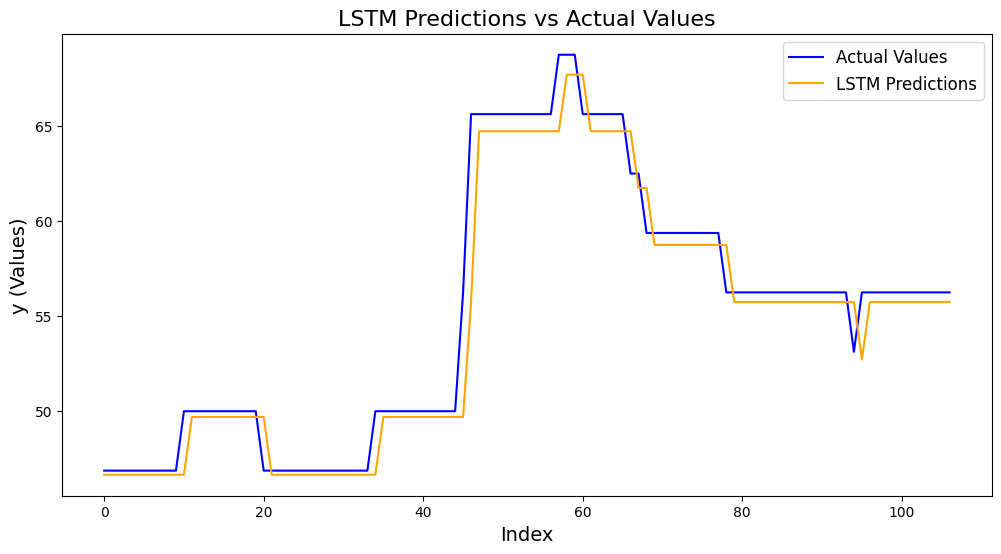

In [234]:
# Extract actual and predicted values for comparison
actual_values = test_data[test_data['Mask'] == 1]['y'][1:]
predicted_values = lstm_pred_aligned

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(actual_values.values, label="Actual Values", color='blue')
plt.plot(predicted_values, label="LSTM Predictions", color='orange')

# Add title, labels, and legend
plt.title("LSTM Predictions vs Actual Values", fontsize=16)
plt.xlabel("Index", fontsize=14)
plt.ylabel("y (Values)", fontsize=14)
plt.legend(fontsize=12)

In [18]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        # Convert numpy arrays to PyTorch tensors
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [19]:
best_seq_length = 1
# Final model with the best sequence length
X_train, y_train = create_sequences(train_scaled['y'].values, best_seq_length)
X_test, y_test = create_sequences(test_scaled['y'].values, best_seq_length)

train_dataset = TimeSeriesDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define and train the final Transformer model
transformer = TransformerModel(input_dim=1, embed_dim=16, num_heads=2, ff_dim=64, num_layers=2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001)
for epoch in range(100):
    transformer.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = transformer(batch_X.unsqueeze(-1))
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
# Make predictions on the test data
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
transformer_pred = transformer(X_test_tensor).detach().numpy()
# Reverse scaling for final predictions
transformer_pred = reverse_scaling(transformer_pred, data)

In [20]:
transformer_pred[test_data['Mask'].iloc[:len(transformer_pred)] == 1].size

107

In [21]:
transformer_pred_aligned = transformer_pred[test_data['Mask'].iloc[:len(transformer_pred)] == 1]

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Align the test data by excluding the first data point
aligned_test_data = test_data[test_data['Mask'] == 1].iloc[1:]  # Skip the first data point

# Calculate MSE and MAE for LSTM predictions
transformer_mse = mean_squared_error(aligned_test_data['y'], transformer_pred_aligned)
transformer_mae = mean_absolute_error(aligned_test_data['y'], transformer_pred_aligned)

print(f"Transformer - Mean Squared Error (MSE): {transformer_mse}")
print(f"Transformer - Mean Absolute Error (MAE): {transformer_mae}")


Transformer - Mean Squared Error (MSE): 16.791541803267563
Transformer - Mean Absolute Error (MAE): 3.7204764574487634


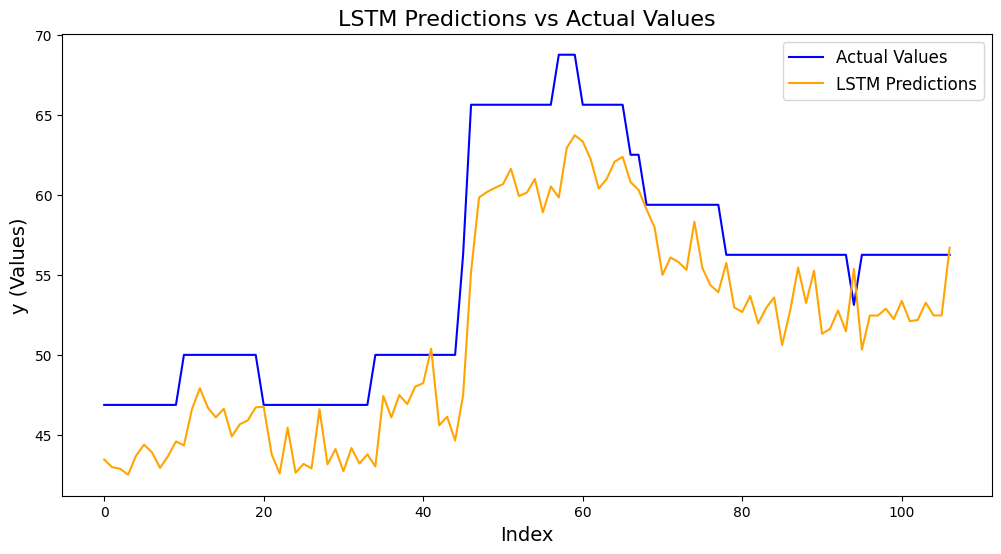

In [23]:
# Extract actual and predicted values for comparison
actual_values = test_data[test_data['Mask'] == 1]['y'][1:]
predicted_values = transformer_pred_aligned
# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(actual_values.values, label="Actual Values", color='blue')
plt.plot(predicted_values, label="LSTM Predictions", color='orange')
# Add title, labels, and legend
plt.title("LSTM Predictions vs Actual Values", fontsize=16)
plt.xlabel("Index", fontsize=14)
plt.ylabel("y (Values)", fontsize=14)
plt.legend(fontsize=12)

In [254]:
# Create a comparison DataFrame
model_comparison = pd.DataFrame({
    'Model': ['SARIMA', 'Prophet', 'Random Forest', 'XGBoost', 'LSTM', 'Transformer'],
    'MSE': [sarima_mse, prophet_mse, rf_mse, xgb_mse, lstm_mse, transformer_mse],
    'MAE': [sarima_mae, prophet_mae, rf_mae, xgb_mae, lstm_mae, transformer_mae]
})

# Sort models by MSE and MAE
model_comparison_sorted = model_comparison.sort_values(by='MSE')

print(model_comparison_sorted)

           Model         MSE        MAE
4           LSTM    2.387835   0.852537
5    Transformer    4.025137   1.455697
2  Random Forest    5.995638   1.577951
3        XGBoost    6.279959   1.569590
0         SARIMA   68.452301   7.401513
1        Prophet  344.997408  16.320782


C:\Windows\Temp\ipykernel_15324\809461196.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=model_comparison_sorted, x='Model', y='MSE', palette='viridis')


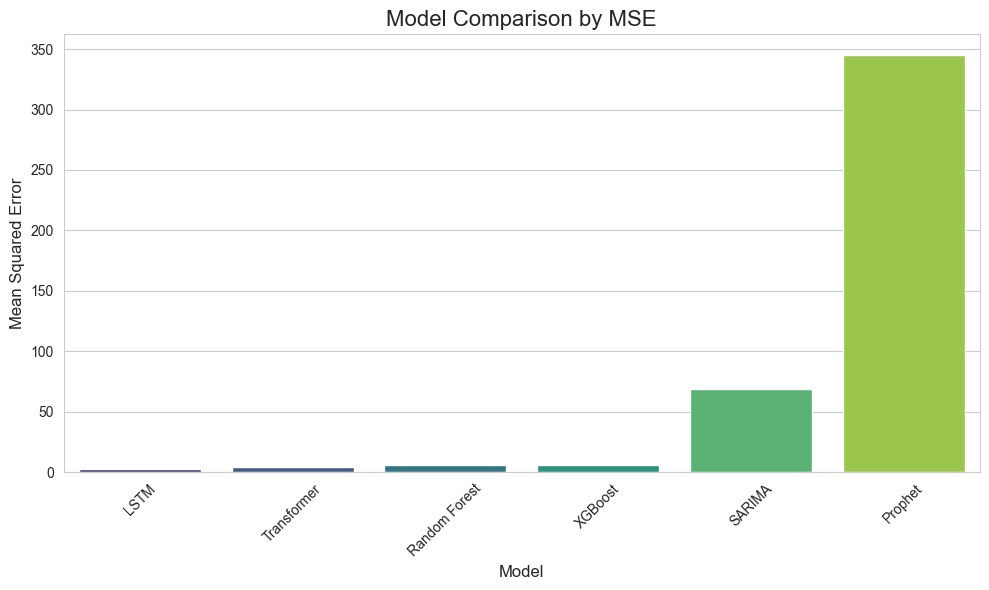

C:\Windows\Temp\ipykernel_15324\809461196.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=model_comparison_sorted, x='Model', y='MAE', palette='coolwarm')


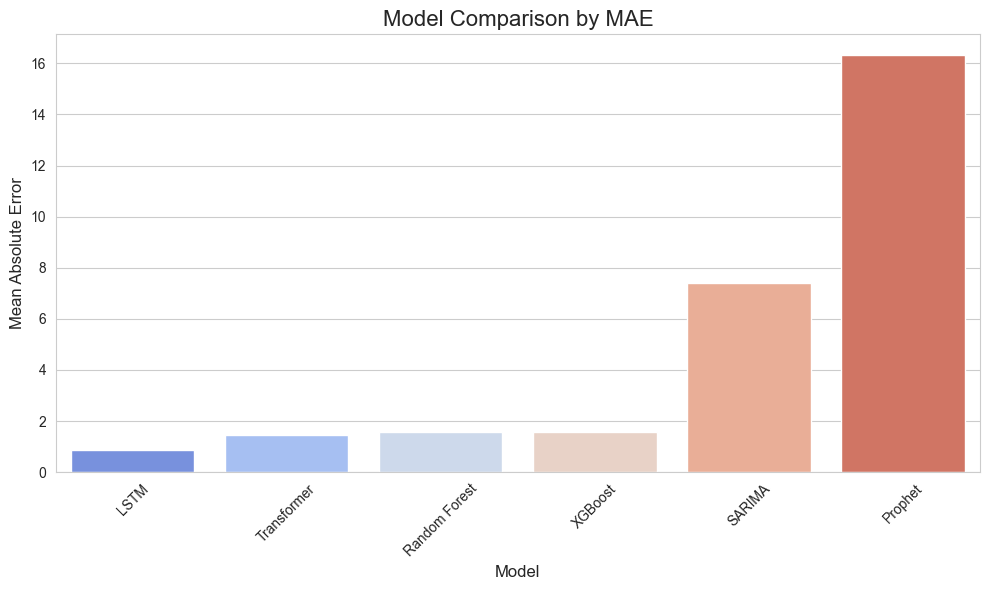

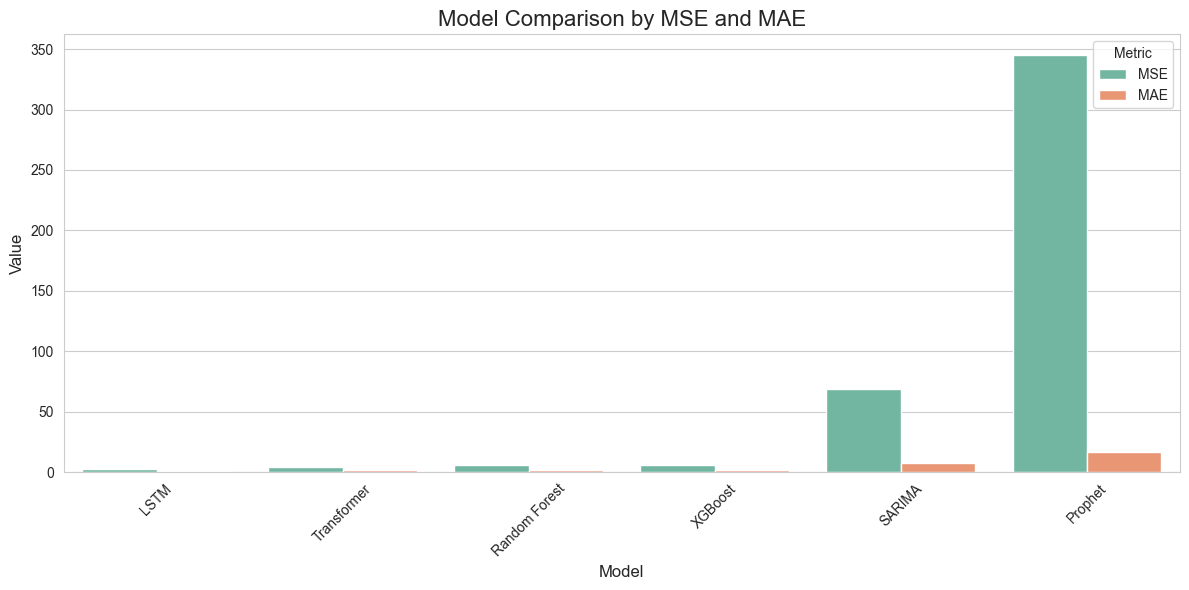

In [255]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set_style('whitegrid')

# Plot MSE for each model
plt.figure(figsize=(10, 6))
sns.barplot(data=model_comparison_sorted, x='Model', y='MSE', palette='viridis')
plt.title('Model Comparison by MSE', fontsize=16)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot MAE for each model
plt.figure(figsize=(10, 6))
sns.barplot(data=model_comparison_sorted, x='Model', y='MAE', palette='coolwarm')
plt.title('Model Comparison by MAE', fontsize=16)
plt.ylabel('Mean Absolute Error', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot MSE and MAE together as a grouped bar plot
melted_comparison = model_comparison_sorted.melt(id_vars='Model', var_name='Metric', value_name='Value')
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_comparison, x='Model', y='Value', hue='Metric', palette='Set2')
plt.title('Model Comparison by MSE and MAE', fontsize=16)
plt.ylabel('Value', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.legend(title='Metric', fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


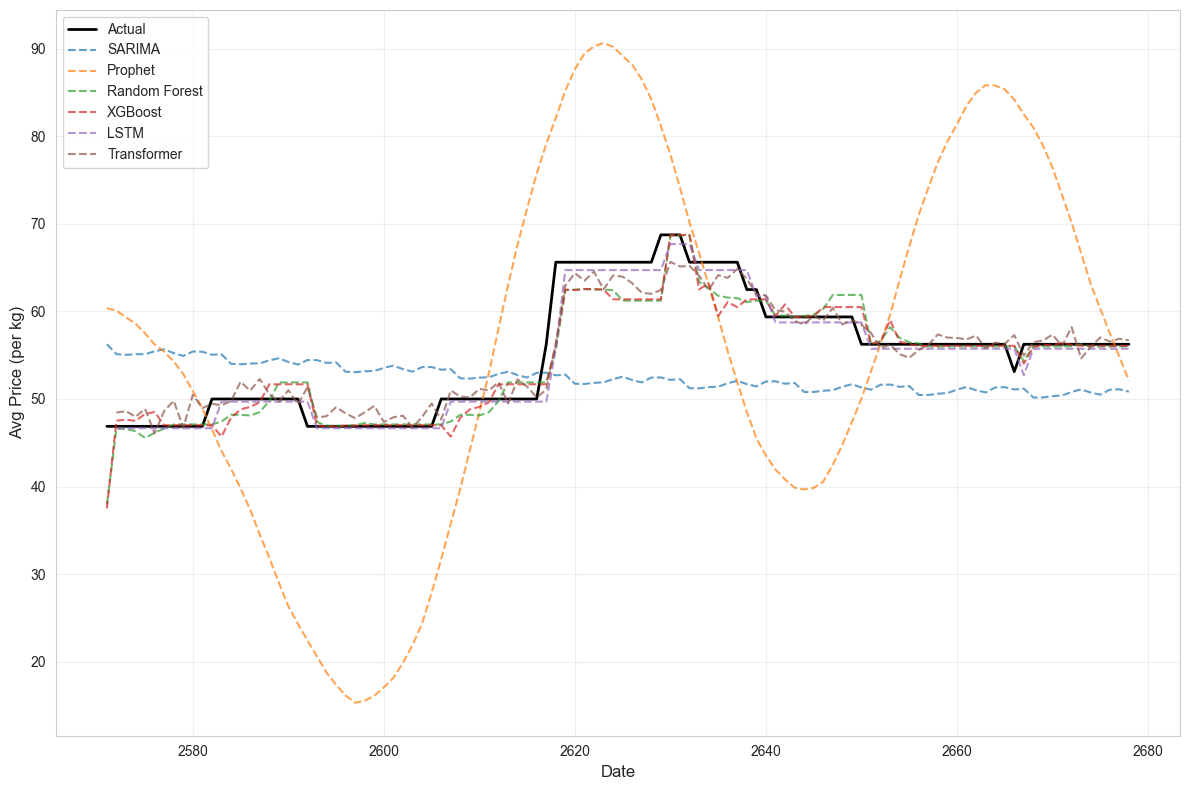

In [256]:
import matplotlib.pyplot as plt

# Actual test values for Mask=1
actual_values = test_data['y'][test_data['Mask'] == 1]

# Plot predictions for each model
plt.figure(figsize=(12, 8))

plt.plot(actual_values.index, actual_values, label='Actual', color='black', linewidth=2)

# Add model predictions
plt.plot(actual_values.index, sarima_pred, label='SARIMA', linestyle='--', alpha=0.7)
plt.plot(actual_values.index, prophet_pred, label='Prophet', linestyle='--', alpha=0.7)
plt.plot(actual_values.index, rf_pred_aligned, label='Random Forest', linestyle='--', alpha=0.7)
plt.plot(actual_values.index, xgb_pred_aligned, label='XGBoost', linestyle='--', alpha=0.7)
plt.plot(actual_values.index[1:], lstm_pred_aligned, label='LSTM', linestyle='--', alpha=0.7)
plt.plot(actual_values.index[1:], transformer_pred_aligned, label='Transformer', linestyle='--', alpha=0.7)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Avg Price (per kg)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show plot
plt.show()
